# 0. Load dataset

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"19B-3kstB9lqhik1w50PkQF2Gbg222yNi"})
downloaded.GetContentFile('datasetpadi.csv')

# 1. Import Dataset

In [ ]:
!pip install pytorch-tabnet
!pip install optuna
import numpy as np
import pandas as pd
import torch
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBClassifier
import optuna
from optuna import Trial, visualization
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 410.6/410.6 MB 75.7 MB/s eta 0:00:01Collecting nvidia-cufft-cu12==11.0.2.54 (from torch>=1.3->pytorch-tabnet)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import time

# 2. Preprocessing

In [ ]:
dataset = pd.read_csv('datasetpadi.csv')

In [ ]:
dataset = dataset.drop(columns=['NO','ID22','BLOK','IMG_DATE','U_2'])
dataset2 = dataset
dataset.head()

,RPIMAX,RPIMXCLS,UMUR,RPI_MEAN,API_MEAN,NDPI_MEAN,VH_MEAN,VV_MEAN,RPI_MODE
0,0.3384,2,-20,0.1738,0.0693,0.7129,0.0192,0.1105,0.1033
1,0.3679,3,-21,0.2328,0.0891,0.6368,0.0303,0.1303,0.1367
2,0.3709,3,-21,0.2079,0.1236,0.6700,0.0364,0.1749,0.1658
3,0.3711,3,-21,0.2255,0.0898,0.6412,0.0308,0.1365,0.1737
4,0.3734,3,-21,0.2183,0.1107,0.6531,0.0361,0.1655,0.1274


In [ ]:
# dataset2 = dataset
a = []
for i in range(len(dataset2)):
  if dataset2['UMUR'][i]<0:
    a.append("Air")
  #elif 0<=dataset2['UMUR'][i] and dataset['UMUR'][i]<=20:
   # a.append("VegetatifAwal")
  elif 0<=dataset2['UMUR'][i] and dataset['UMUR'][i]<=40:
    a.append("Vegetatif1")
  elif 41<=dataset2['UMUR'][i] and dataset['UMUR'][i]<=64:
    a.append("Vegetatif2")
  elif 65<=dataset2['UMUR'][i] and dataset['UMUR'][i]<=90:
    a.append("Generatif1")
  elif 91<=dataset2['UMUR'][i] and dataset['UMUR'][i]<=120:
    a.append("Generatif2")
  else:
    a.append("Bera")
print(a)

['Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Vegetatif1', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Vegetatif1', 'Vegetatif1', 'Vegetatif1', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air', 'Air'

In [ ]:
dataset['Fase'] = a
#dataset = dataset.drop(['UMUR'], axis = 1)
dataset.head()

,RPIMAX,RPIMXCLS,UMUR,RPI_MEAN,API_MEAN,NDPI_MEAN,VH_MEAN,VV_MEAN,RPI_MODE,Fase
0,0.3384,2,-20,0.1738,0.0693,0.7129,0.0192,0.1105,0.1033,Air
1,0.3679,3,-21,0.2328,0.0891,0.6368,0.0303,0.1303,0.1367,Air
2,0.3709,3,-21,0.2079,0.1236,0.6700,0.0364,0.1749,0.1658,Air
3,0.3711,3,-21,0.2255,0.0898,0.6412,0.0308,0.1365,0.1737,Air
4,0.3734,3,-21,0.2183,0.1107,0.6531,0.0361,0.1655,0.1274,Air


In [ ]:
y = dataset.pop("Fase")
X = dataset.drop(['UMUR'], axis = 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify = y)

# 3. TabNet

In [ ]:
x_train = X_train.to_numpy()
x_train

array([[0.3972, 4.    , 0.2836, ..., 0.0233, 0.0823, 0.1831],
       [0.3851, 4.    , 0.379 , ..., 0.0307, 0.0811, 0.2696],
       [0.371 , 3.    , 0.1852, ..., 0.0191, 0.1034, 0.0727],
       ...,
       [0.32  , 2.    , 0.1292, ..., 0.0161, 0.1248, 0.0958],
       [0.3677, 3.    , 0.1585, ..., 0.0303, 0.1909, 0.1239],
       [0.4033, 4.    , 0.3134, ..., 0.0228, 0.0728, 0.2466]])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm


# Assuming you have your data loaded into X and y

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define TabNet parameters
tabnet_params = {
    "n_d": [2, 4, 8, 16],           # Example values, you can modify these
    "n_a": [2, 4, 8, 16],
    "n_steps": [2, 4, 8, 16],
    "gamma": [1.3, 1.5, 1.7],
    "n_shared": [2, 4, 8, 16],
    "lambda_sparse": [1e-4, 1e-5],
    "optimizer_fn": [torch.optim.Adam],
    "optimizer_params": [{"lr": 0.1, "weight_decay": 1e-4}],
    "mask_type": ["sparsemax"],
    "scheduler_params": [{"mode": "min", "patience": 15, "min_lr": 1e-5, "factor": 0.1}],
    "scheduler_fn": [torch.optim.lr_scheduler.ReduceLROnPlateau],
    "verbose": [1],
}

# Create TabNet classifier
tabnet = TabNetClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(tabnet, tabnet_params, cv=2, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train.values, y_train.values)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_tabnet = grid_search.best_estimator_

# Make predictions on the test set
test_preds = best_tabnet.predict(X_test.values)

# Evaluate accuracy
accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {accuracy}")

Fitting 2 folds for each of 1536 candidates, totalling 3072 fits


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score

# Assuming you have your data loaded into x_train and y_train
# Split the data into training and validation sets
# Convert data to PyTorch tensors if not already
# x_train_tensor = torch.FloatTensor(x_train.values)
# y_train_tensor = torch.LongTensor(y_train.values)

# x_valid_tensor = torch.FloatTensor(x_valid.values)
# y_valid_tensor = torch.LongTensor(y_valid.values)
import time

# Record the start time
start_time = time.time()
# Define TabNet parameters
tabnet_params = {
"n_d": 16,
    "n_a": 16,
    "n_steps": 4,
    "gamma": 1.3,
    "n_shared": 4,
    "lambda_sparse": 1e-3,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2, weight_decay=1e-5),
    "mask_type": "sparsemax",
    "scheduler_params": {"mode": "min", "patience": 15, "min_lr": 1e-5, "factor": 0.5},
    "scheduler_fn": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "verbose": 1,
}

# Initialize and train the TabNet model
clf = TabNetClassifier(**tabnet_params, device_name = 'cuda')
clf.fit(
    X_train=X_train.values,
    y_train=y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    patience=500,
    max_epochs=1500,
    eval_metric=["accuracy"],
)

# Make predictions on the validation set
valid_preds = clf.predict(x_test.values)

# Evaluate accuracy
accuracy = accuracy_score(y_test, valid_preds)
print(f"Validation Accuracy: {accuracy}")
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(elapsed_time)

epoch 0  | loss: 2.24224 | val_0_accuracy: 0.1706  |  0:00:00s
epoch 1  | loss: 1.86592 | val_0_accuracy: 0.19554 |  0:00:00s
epoch 2  | loss: 1.74221 | val_0_accuracy: 0.1916  |  0:00:01s
epoch 3  | loss: 1.6873  | val_0_accuracy: 0.29528 |  0:00:01s
epoch 4  | loss: 1.68695 | val_0_accuracy: 0.25525 |  0:00:01s
epoch 5  | loss: 1.65984 | val_0_accuracy: 0.29528 |  0:00:01s
epoch 6  | loss: 1.64712 | val_0_accuracy: 0.29199 |  0:00:02s
epoch 7  | loss: 1.64812 | val_0_accuracy: 0.29265 |  0:00:02s
epoch 8  | loss: 1.63534 | val_0_accuracy: 0.29528 |  0:00:02s
epoch 9  | loss: 1.63216 | val_0_accuracy: 0.29528 |  0:00:02s
epoch 10 | loss: 1.62544 | val_0_accuracy: 0.29528 |  0:00:03s
epoch 11 | loss: 1.63288 | val_0_accuracy: 0.29528 |  0:00:03s
epoch 12 | loss: 1.62616 | val_0_accuracy: 0.29528 |  0:00:03s
epoch 13 | loss: 1.62762 | val_0_accuracy: 0.29528 |  0:00:04s
epoch 14 | loss: 1.62971 | val_0_accuracy: 0.29528 |  0:00:04s
epoch 15 | loss: 1.62125 | val_0_accuracy: 0.29528 |  0

In [ ]:
elapsed_time

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score
cm = confusion_matrix(y_test, valid_preds)
cm

In [ ]:
print('train',accuracy_score(y_train, clf.predict(x_train)))

train 0.7310829817158931


In [ ]:
print('test',accuracy_score(y_test, valid_preds))

test 0.6981627296587927


In [ ]:
cohen_kappa_score(y_test, valid_preds)

0.618731454328701

# 10 Times TabNet

In [ ]:
import time
def tabnet(x_train, y_train, x_test, y_test):
  start_time = time.time()
# Define TabNet parameters
  tabnet_params = {
    "n_d": 16,
    "n_a": 16,
    "n_steps": 4,
    "gamma": 1.3,
    "n_shared": 4,
    "lambda_sparse": 1e-3,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2, weight_decay=1e-5),
    "mask_type": "sparsemax",
    "scheduler_params": {"mode": "min", "patience": 15, "min_lr": 1e-5, "factor": 0.5},
    "scheduler_fn": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "verbose": 1,
  }

# Initialize and train the TabNet model
  clf = TabNetClassifier(**tabnet_params)
  clf.fit(
      X_train=x_train.values,
      y_train=y_train.values,
      eval_set=[(x_test.values, y_test.values)],
      patience=500,
      max_epochs=1500,
      eval_metric=["accuracy"],
  )

# Make predictions on the validation set
  valid_preds = clf.predict(x_test.values)

# Evaluate accuracy
  accuracy = accuracy_score(y_test, valid_preds)
  kappa = cohen_kappa_score(y_test, valid_preds)
  print(f"Validation Accuracy: {accuracy}")
  cm = confusion_matrix(y_test, valid_preds)
  end_time = time.time()

# Calculate the elapsed time
  elapsed_time = end_time - start_time
  return elapsed_time, accuracy, kappa, cm

In [ ]:
acc = []
kappa = []
eta = []
pred = []
random_seed = range(0,1)
for i in random_seed:
  x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.3, stratify = y)
  eta_temp, acc_temp, kappa_temp, cm = tabnet(x_train, y_train, x_test, y_test)
  acc.append(acc_temp)
  kappa.append(kappa_temp)
  eta.append(eta_temp)
  pred.append(cm)

epoch 0  | loss: 1.89119 | val_0_accuracy: 0.23556 |  0:00:00s
epoch 1  | loss: 1.36615 | val_0_accuracy: 0.39173 |  0:00:00s
epoch 2  | loss: 1.15215 | val_0_accuracy: 0.16601 |  0:00:01s
epoch 3  | loss: 0.98276 | val_0_accuracy: 0.1706  |  0:00:01s
epoch 4  | loss: 0.9024  | val_0_accuracy: 0.1706  |  0:00:01s
epoch 5  | loss: 0.82767 | val_0_accuracy: 0.1706  |  0:00:01s
epoch 6  | loss: 0.82885 | val_0_accuracy: 0.1706  |  0:00:02s
epoch 7  | loss: 0.78701 | val_0_accuracy: 0.1706  |  0:00:02s
epoch 8  | loss: 0.7525  | val_0_accuracy: 0.1706  |  0:00:02s
epoch 9  | loss: 0.73062 | val_0_accuracy: 0.1706  |  0:00:03s
epoch 10 | loss: 0.72453 | val_0_accuracy: 0.1706  |  0:00:03s
epoch 11 | loss: 0.71915 | val_0_accuracy: 0.1706  |  0:00:03s
epoch 12 | loss: 0.70568 | val_0_accuracy: 0.1706  |  0:00:03s
epoch 13 | loss: 0.69464 | val_0_accuracy: 0.1706  |  0:00:04s
epoch 14 | loss: 0.70559 | val_0_accuracy: 0.1706  |  0:00:04s
epoch 15 | loss: 0.67623 | val_0_accuracy: 0.1706  |  0

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

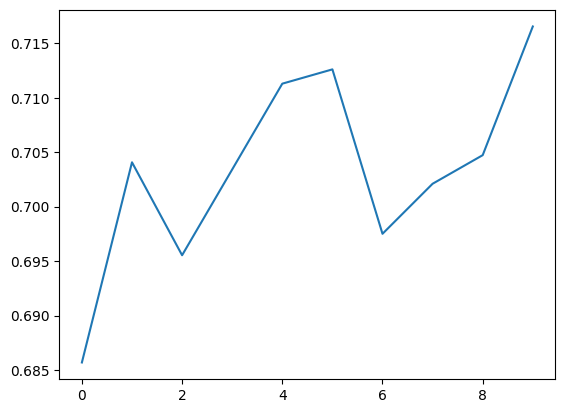

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)

In [ ]:
y_test.shape

(1524,)

In [ ]:
y_test.value_counts()

Vegetatif1    450
Generatif1    294
Generatif2    292
Vegetatif2    260
Air           203
Bera           25
Name: Fase, dtype: int64

In [ ]:
pred[0][3][2] = 79

In [ ]:
pred[0]

array([[116,   0,   2,   5,  42,  38],
       [  4,   8,   0,  12,   1,   0],
       [  1,   0, 209,  37,   0,  47],
       [ 13,   3,  79, 195,   0,   2],
       [ 32,   0,   1,   0, 386,  31],
       [ 18,   0,  33,   1,  30, 178]])

In [ ]:
for i in pred[0]:
  print(sum(i))
#harus ada 1092

NameError: name 'pred' is not defined

In [ ]:
cm = [[116,0,2,5,42,38],
     [4,8,0,12,1,0],
     [1,0,209,37,0,47],
     [13,3,79,195,0,2],
     [32,0,1,0,386,31],
     [18,0,33,1,30,178]]

Text(50.72222222222221, 0.5, 'Ground Truth')

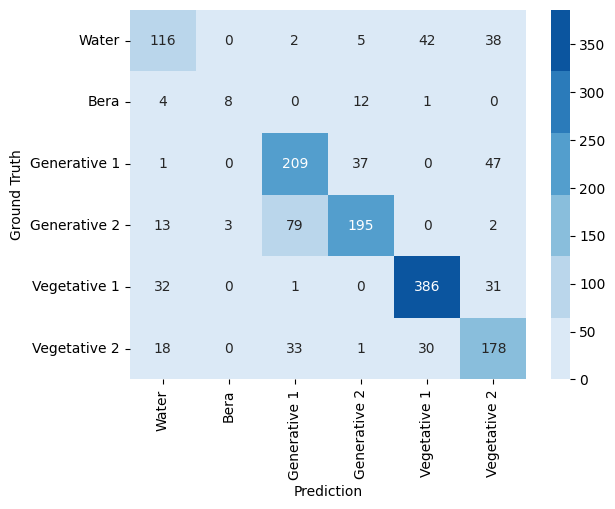

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
colormap = sns.color_palette("Blues")
yticklabels = ['Water', 'Bera', 'Generative 1', 'Generative 2', 'Vegetative 1', 'Vegetative 2']
sns.heatmap(cm, annot = True, cmap = colormap, fmt = 'g', yticklabels=yticklabels, xticklabels = yticklabels)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

In [ ]:
csv_tabnet = pd.DataFrame(columns = ['experiments', 'accuracy', 'kappa', 'running time'])
csv_tabnet['experiments'] = range(1,11)
csv_tabnet['accuracy'] = acc
csv_tabnet['kappa'] = kappa
csv_tabnet['running time'] = eta
csv_tabnet.head()

,experiments,accuracy,kappa,running time
0,1,0.685696,0.602288,263.642601
1,2,0.704068,0.625225,289.143887
2,3,0.695538,0.614784,271.676691
3,4,0.703412,0.625435,246.028798
4,5,0.711286,0.635148,264.350264


In [ ]:
csv_tabnet.to_csv('csv_tabnet.csv')

# 4. Random Forest

In [ ]:
start_time = time.time()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 200, max_depth = 4, min_samples_leaf = 4, min_samples_split = 2, max_leaf_nodes = 70,)
n_estimators = [100,200]
max_features = ['sqrt', 'log2']
max_depth = [6,7,8]
hyperparameters2 = dict(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth)
clf2 = GridSearchCV(rf, hyperparameters2, cv=4, verbose=0)
best_model2 = clf2.fit(X_train, y_train)
print('Best Score: ', clf2.best_score_)
print('Best Params: ', clf2.best_params_)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(elapsed_time)

Best Score:  0.2900123126501079
Best Params:  {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
35.25138711929321


In [ ]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 4, min_samples_leaf = 4, min_samples_split = 2, max_leaf_nodes = 70,)
best_model2 = rf.fit(X_train, y_train)

In [ ]:
y_pred = best_model2.predict(X_test)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_test,y_pred))
print('Train Accuracy = ',accuracy_score(y_train,best_model2.predict(X_train)))
print('Test Accuracy = ',accuracy_score(y_test,y_pred))
print('Train Precision = ',precision_score(y_train,best_model2.predict(X_train), average = 'macro'))
print('Test Precision = ',precision_score(y_test,y_pred, average = 'macro'))
print('Train Recall = ',recall_score(y_train,best_model2.predict(X_train), average = 'macro'))
print('Test Recall = ',recall_score(y_test,y_pred, average = 'macro'))
print('F1 Score = ',f1_score(y_test,y_pred, average = 'macro'))

Confusion Matrix
[[  0   0   0   0 203   0]
 [  0   0   0   0  25   0]
 [  0   0   0   0 294   0]
 [  0   0   0   0 292   0]
 [  0   0   1   0 449   0]
 [  0   0   0   0 260   0]]
Train Accuracy =  0.2978902953586498
Test Accuracy =  0.2946194225721785
Train Precision =  0.4868931696302568
Test Precision =  0.04913547822280587
Train Recall =  0.16894954079523394
Test Recall =  0.1662962962962963
F1 Score =  0.07585740834600439


In [ ]:
y_test.value_counts()

Vegetatif1    450
Generatif1    294
Generatif2    292
Vegetatif2    260
Air           203
Bera           25
Name: Fase, dtype: int64

0.22769028871391075


<Axes: >

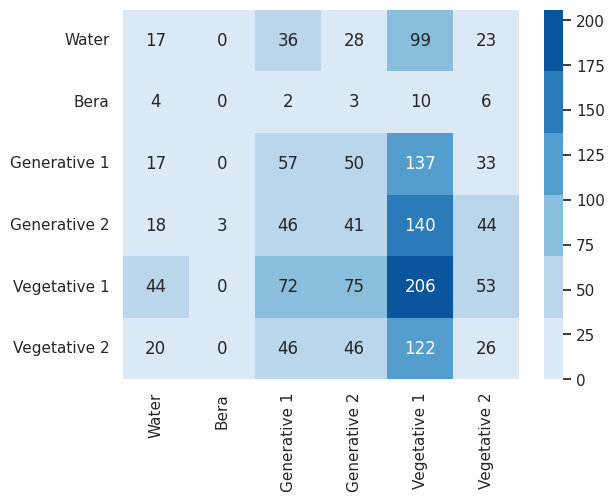

In [ ]:
print(accuracy_score(y_test,y_pred))
import seaborn as sns
colormap = sns.color_palette("Blues")
yticklabels = ['Water', 'Bera', 'Generative 1', 'Generative 2', 'Vegetative 1', 'Vegetative 2']
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, cmap = colormap, fmt = 'g', yticklabels=yticklabels, xticklabels = yticklabels)

# 10 TImes RF

In [ ]:
import time
def rf(x_train, y_train, x_test, y_test):
  start_time = time.time()
# Define TabNet parameters
  rf = RandomForestClassifier(n_estimators = 200, max_depth = 4, min_samples_leaf = 4, min_samples_split = 2, max_leaf_nodes = 70,)
  rf.fit(x_train, y_train)
  valid_preds = rf.predict(x_test)
# Evaluate accuracy
  accuracy = accuracy_score(y_test, valid_preds)
  kappa = cohen_kappa_score(y_test, valid_preds)
  cm = confusion_matrix(y_test, valid_preds)
  print(f"Validation Accuracy: {accuracy}")
  end_time = time.time()

# Calculate the elapsed time
  elapsed_time = end_time - start_time
  return elapsed_time, accuracy, kappa,cm

In [ ]:
acc_rf = []
kappa_rf = []
eta_rf = []
cm = []
random_seed = range(0,10)
for i in random_seed:
  x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = i, test_size = 0.3, stratify = y)
  eta_temp, acc_temp, kappa_temp,prediction = rf(x_train, y_train, x_test, y_test)
  acc_rf.append(acc_temp)
  kappa_rf.append(kappa_temp)
  eta_rf.append(eta_temp)
  cm.append(prediction)

Validation Accuracy: 0.6679790026246719
Validation Accuracy: 0.6837270341207349
Validation Accuracy: 0.6824146981627297
Validation Accuracy: 0.6850393700787402
Validation Accuracy: 0.6804461942257218
Validation Accuracy: 0.6942257217847769
Validation Accuracy: 0.6738845144356955
Validation Accuracy: 0.6811023622047244
Validation Accuracy: 0.6778215223097113
Validation Accuracy: 0.6922572178477691


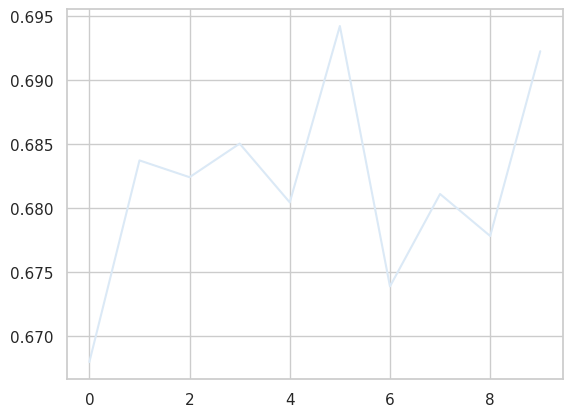

In [ ]:
plt.plot(acc_rf)

In [ ]:
cm[5]

[[...], [...], [...], [...], [...], [...], [...], [...], [...], [...]]

Text(46.24999999999999, 0.5, 'Ground Truth')

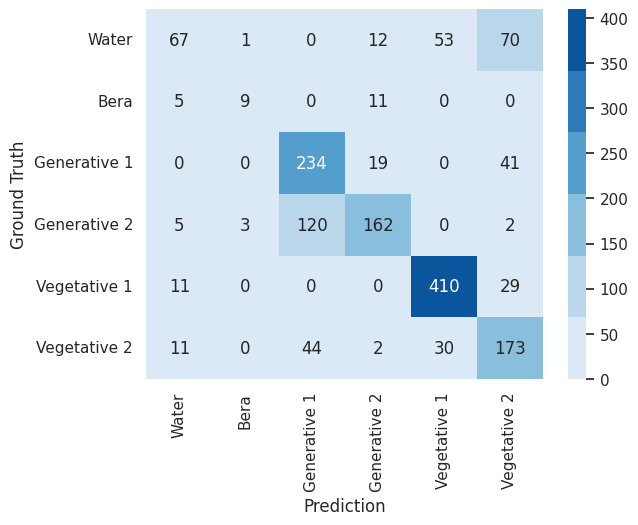

In [ ]:
import seaborn as sns
colormap = sns.color_palette("Blues")
yticklabels = ['Water', 'Bera', 'Generative 1', 'Generative 2', 'Vegetative 1', 'Vegetative 2']
sns.heatmap(cm[-1], annot = True, cmap = colormap, fmt = 'g', yticklabels=yticklabels, xticklabels = yticklabels)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

In [ ]:
csv_rf = pd.DataFrame(columns = ['experiments', 'accuracy', 'kappa', 'running time'])
csv_rf['experiments'] = range(1,11)
csv_rf['accuracy'] = acc_rf
csv_rf['kappa'] = kappa_rf
csv_rf['running time'] = eta_rf
csv_rf.head()

,experiments,accuracy,kappa,running time
0,1,0.666010,0.574046,0.704612
1,2,0.679790,0.592641,0.717341
2,3,0.682415,0.596007,0.695299
3,4,0.677165,0.588668,0.709300
4,5,0.681759,0.595487,0.733710


In [ ]:
csv_rf.to_csv('csv_rf.csv')

# 5. XGBoost

In [ ]:
y_train_XG = y_train.map({"Bera": 0, "Generatif1": 1, "Generatif2": 2, "Air": 3, "Vegetatif1": 4, "Vegetatif2": 5})
y_test_XG = y_test.map({"Bera": 0, "Generatif1": 1, "Generatif2": 2, "Air": 3, "Vegetatif1": 4, "Vegetatif2": 5})

In [ ]:
start_time = time.time()
# create an xgboost regression model
model = XGBClassifier(n_estimators = 80, eta = 0.05, max_depth = 6, min_child_weight = 10,)
model.fit(X_train,y_train_XG)
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(elapsed_time)

0.7386066913604736


In [ ]:
pred2 = model.predict(X_test)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_test_XG,pred2))
print('Train Accuracy = ',accuracy_score(y_train_XG,model.predict(X_train)))
print('Test Accuracy = ',accuracy_score(y_test_XG,pred2))
print('Train Precision = ',precision_score(y_train_XG,model.predict(X_train), average = 'macro'))
print('Test Precision = ',precision_score(y_test_XG,pred2, average = 'macro'))
print('Train Recall = ',recall_score(y_train_XG,model.predict(X_train), average = 'macro'))
print('Test Recall = ',recall_score(y_test_XG,pred2, average = 'macro'))
print('F1 Score = ',f1_score(y_test_XG,pred2, average = 'macro'))

Confusion Matrix
[[  0   5   0   1  17   2]
 [  0  42  32   6 209   5]
 [  0  27  37   2 212  14]
 [  0  22  15   5 155   6]
 [  0  52  46   3 333  16]
 [  0  24  27   3 200   6]]
Train Accuracy =  0.4452883263009845
Test Accuracy =  0.27755905511811024
Train Precision =  0.48231798869750686
Test Precision =  0.19134015641168467
Train Recall =  0.31065665328048003
Test Recall =  0.17621282276218506
F1 Score =  0.14188917240395849


In [ ]:
cohen_kappa_score(y_test_XG,pred2)

0.01453017154294678

In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

# 10 Times XGBoost

In [ ]:
import time
def xgboost(x_train, y_train, x_test, y_test):
  start_time = time.time()
# create an xgboost regression model
  model = XGBClassifier(n_estimators = 80, eta = 0.05, max_depth = 6, min_child_weight = 10,)
  model.fit(x_train,y_train)
  pred2 = model.predict(x_test)
  accuracy = accuracy_score(y_test,pred2)
  kappa = cohen_kappa_score(y_test,pred2)
  cm = confusion_matrix(y_test, pred2)
  print('Test Accuracy = ', accuracy)
  end_time = time.time()

# Calculate the elapsed time
  elapsed_time = end_time - start_time

# Calculate the elapsed time
  elapsed_time = end_time - start_time
  return elapsed_time, accuracy, kappa, cm

In [ ]:
acc_xgb = []
kappa_xgb = []
eta_xgb = []
cm = []
random_seed = range(0,10)
for i in random_seed:
  x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = i, test_size = 0.3, stratify = y)
  y_train_XG = y_train.map({"Bera": 0, "Generatif1": 1, "Generatif2": 2, "Air": 3, "Vegetatif1": 4, "Vegetatif2": 5})
  y_test_XG = y_test.map({"Bera": 0, "Generatif1": 1, "Generatif2": 2, "Air": 3, "Vegetatif1": 4, "Vegetatif2": 5})
  eta_temp, acc_temp, kappa_temp, pred = xgboost(x_train, y_train_XG, x_test, y_test_XG)
  acc_xgb.append(acc_temp)
  kappa_xgb.append(kappa_temp)
  eta_xgb.append(eta_temp)
  cm.append(pred)


Test Accuracy =  0.6981627296587927
Test Accuracy =  0.699475065616798
Test Accuracy =  0.702755905511811
Test Accuracy =  0.7112860892388452
Test Accuracy =  0.7073490813648294
Test Accuracy =  0.7086614173228346
Test Accuracy =  0.702755905511811
Test Accuracy =  0.7112860892388452
Test Accuracy =  0.6889763779527559
Test Accuracy =  0.7014435695538058


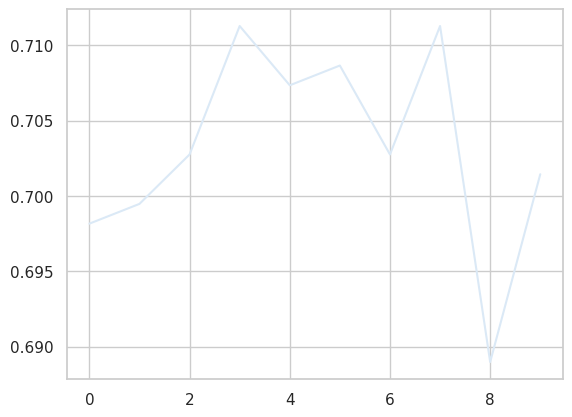

In [ ]:
plt.plot(acc_xgb)

In [ ]:
sum(acc_xgb)/10

0.7032152230971128

In [ ]:
cm[3]

array([[  8,   0,   8,   8,   0,   1],
       [  0, 214,  45,   2,   0,  33],
       [  3,  65, 211,  13,   0,   0],
       [  1,   0,  10, 109,  38,  45],
       [  0,   0,   1,  30, 379,  40],
       [  0,  44,   2,  18,  33, 163]])

In [ ]:
y_test.value_counts()

Vegetatif1    450
Generatif1    294
Generatif2    292
Vegetatif2    260
Air           203
Bera           25
Name: Fase, dtype: int64

In [ ]:
for i in cm[3]:
  print(sum(i))

25
294
292
203
450
260


Text(46.24999999999999, 0.5, 'Ground Truth')

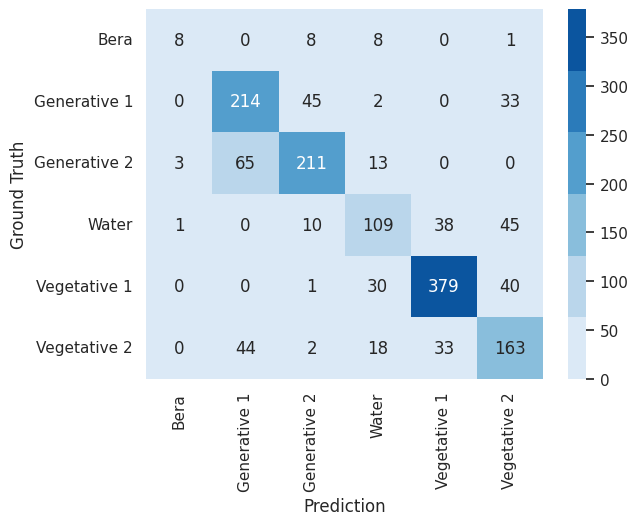

In [ ]:
import seaborn as sns
colormap = sns.color_palette("Blues")
yticklabels = ['Bera', 'Generative 1', 'Generative 2', 'Water', 'Vegetative 1', 'Vegetative 2']
sns.heatmap(cm[3], annot = True, cmap = colormap, fmt = 'g', yticklabels=yticklabels, xticklabels = yticklabels)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')

In [ ]:
csv_xgb = pd.DataFrame(columns = ['experiments', 'accuracy', 'kappa', 'running time'])
csv_xgb['experiments'] = range(1,11)
csv_xgb['accuracy'] = acc_xgb
csv_xgb['kappa'] = kappa_xgb
csv_xgb['running time'] = eta_xgb
csv_xgb.head()

,experiments,accuracy,kappa,running time
0,1,0.698163,0.616973,0.581790
1,2,0.699475,0.619022,0.412787
2,3,0.702756,0.623702,0.394488
3,4,0.711286,0.634387,0.382751
4,5,0.707349,0.629464,0.403942


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-17bba31f-4406-3388-65fe-318ca4bb7a74)


In [ ]:
csv_xgb.to_csv('csv_xgb.csv')